# PV056 project

### Follow the instructions and run the cells in this notebook to reproduce all the results.

In [1]:
!pip3 install requests
!pip3 install matplotlib
!pip3 install pandas
!pip3 install datasets
!pip3 install transformers[torch]
!pip3 install matplotlib
!pip install -U ipywidgets
!pip install scikit-learn
!pip3 install -r food-hazard-detection/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import random
import sys
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import requests
import pandas as pd
import matplotlib.pyplot as plt

os.environ["WANDB_DISABLED"] = "true"
sys.path.append('/content/food-hazard-detection')

## Load the datasets

In [3]:
dataset_parts = ["train", "test", "valid"]
for dataset_part in dataset_parts:
    url = f"https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_{dataset_part}.csv"
    response = requests.get(url)

    with open(f"incidents_{dataset_part}.csv", "wb") as f:
        f.write(response.content)

trainset = pd.read_csv('incidents_train.csv', index_col=0)
validset = pd.read_csv('incidents_valid.csv', index_col=0)
testset = pd.read_csv('incidents_valid.csv', index_col=0)

for dataset in [trainset, validset, testset]:
    dataset.rename(columns={"hazard-category": "hazard_category", "product-category": "product_category"}, inplace=True)

## Explore the data

In [4]:
trainset.sample()

,year,month,day,country,title,text,hazard_category,product_category,hazard,product
5707,2022,3,26,uk,Scratch Meals recalls Scratch Chicken &amp; Ve...,Scratch Meals Ltd is recalling Scratch Chicken...,chemical,prepared dishes and snacks,heavy metals,frozen prepared dish of chicken tikka masala w...


In [5]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5082 entries, 0 to 5983
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard_category   5082 non-null   object
 7   product_category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 436.7+ KB


In [6]:
trainset.head()

,year,month,day,country,title,text,hazard_category,product_category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [7]:
for i in range(10):
    x = random.randint(0, len(trainset))
    print(trainset["text"][x])       # change the column name to view another column data
    print()
    print("XXX")
    print()

PRA No. 1999/3982 Date published 15 Jun 1999 Product description Koala Brand. Best Before 22 March 2000. L5. Packaged On 22 March 1999 And Became Available Shortly After That Date Throughout Australia. What are the defects? May Contain Foreign Matter Including Gravel. What are the hazards? Contamination What should consumers do? Return To Place Of Purchase For A Full Refund. For Further Information Contact Ricegrowers' Co-operative Ltd On Freecall 1800 357555. Supplier Ricegrowers' Co-operative Limited Where the product was sold Nationally Coordinating agency Food Standards Australia New Zealand is the coordinating agency for this recall. Product category Groceries × Close

XXX

GIANT Food Stores, LLC is voluntarily recalling Private Brand Frozen Broccoli Cuts (16 oz.) with sell by date of Mar 15, 2020 and UPC code 68826700926 out of an abundance of caution following a supplier notification that the product may have Listeria monocytogenes.
GIANT/MARTIN’S has removed all affected produc

KeyError: 3661

In [ ]:
#DISTRIBUTION OF HAZARDS IN DATASET
fig, ax = plt.subplots()

ax.barh(trainset['hazard_category'].value_counts().index.to_list(), trainset['hazard_category'].value_counts().values, orientation='horizontal')

plt.xlabel('Frequency')
plt.ylabel('Type of hazard')
plt.title('Distribution of hazard category')
plt.show()

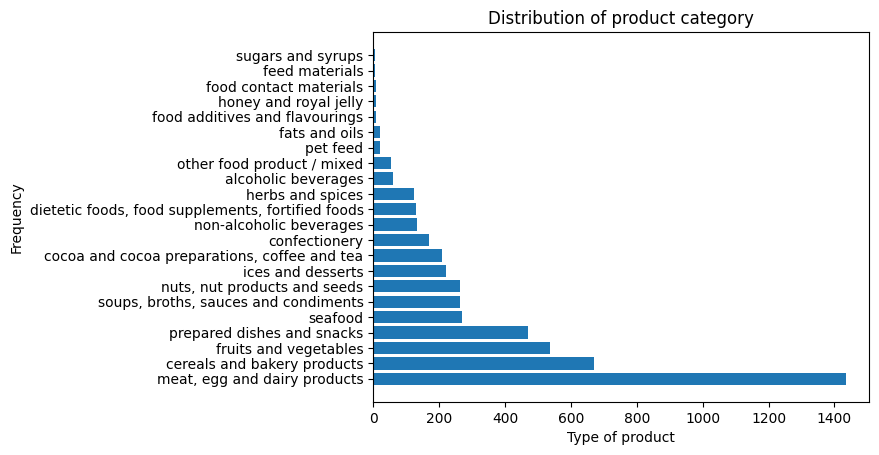

In [8]:
#DISTRIBUTION OF PRODUCT TYPES IN DATASET
fig, ax = plt.subplots()

ax.barh(trainset['product_category'].value_counts().index.to_list(), trainset['product_category'].value_counts().values, orientation='horizontal')

plt.xlabel('Type of product')
plt.ylabel('Frequency')
plt.title('Distribution of product category')
plt.show()


## Generate synthetic data for rare product and hazard categories

In [9]:
from food_hazard_detection.balance_dataset import (generate_prompt_triplets_by_hazard, generate_prompt_triplets_by_product,
                             generate_synthetic_data)

from food_hazard_detection import settings
from food_hazard_detection.settings import FILES_DIR, SYNTHETIC_DATA_DIR

rare_hazard_categories = ["migration", "food additives and flavourings",
                              "organoleptic aspects", "packaging defect"]
rare_product_categories = ["sugars and syrups", "feed materials", "food contact materials",
                           "honey and royal jelly", "food additives and flavourings", "fats and oils",
                           "pet feed", "other food product / mixed", "alcoholic beverages"]

ModuleNotFoundError: No module named 'mistralai'

In [10]:
combinations_hazard = generate_prompt_triplets_by_hazard(rare_hazard_categories, trainset)
generate_synthetic_data(SYNTHETIC_DATA_DIR / "synthetic_data_hazard.csv",
                        FILES_DIR / "prompts/generate_synthetic_data.md", combinations_hazard)

combinations_product = generate_prompt_triplets_by_product(rare_product_categories, trainset)
generate_synthetic_data(SYNTHETIC_DATA_DIR / "synthetic_data_product.csv",
                        FILES_DIR / "prompts/generate_synthetic_data.md", combinations_product)

print("Number of generated synthetic data points:", len(combinations_hazard)+len(combinations_product))

NameError: name 'generate_prompt_triplets_by_hazard' is not defined

The data produced by Mistral are not perfect. So at this point some manual curration is needed (e.g. quote the text column to parse the csv properly or drop some rows with missing values). Because of that, we use later in the code already preprocessed synthetic data.

Load and check the generated data.
We generated smaller and bigger amount of synthetic data and we want to test whether it has some impact on performance.

In [11]:
synthetic_data_small = pd.read_csv(SYNTHETIC_DATA_DIR / "synthetic_data_small.csv")
print(synthetic_data_small.info())

NameError: name 'SYNTHETIC_DATA_DIR' is not defined

In [12]:
synthetic_data_big = pd.read_csv(SYNTHETIC_DATA_DIR / "synthetic_data_big.csv")
print(synthetic_data_big.info())

NameError: name 'SYNTHETIC_DATA_DIR' is not defined

In [13]:
train_small = pd.concat([trainset, synthetic_data_small], ignore_index=True)
train_big = pd.concat([trainset, synthetic_data_big], ignore_index=True)

NameError: name 'synthetic_data_small' is not defined

# Bert and RoBERTa
- [Bert](https://huggingface.co/docs/transformers/model_doc/bert)
- [RoBERTa](https://huggingface.co/docs/transformers/model_doc/roberta)

In [14]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertTokenizer, BertForSequenceClassification, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
import torch

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
def assign_labels(dataset, column, label_dict):
    # autoencoding
    unique_values = dataset[column].unique()
    for value in unique_values:
        if value not in label_dict:
            label_dict[value] = len(label_dict)


def transform_dataset(dataset):
    for split in dataset.keys():
        dataset[split] = dataset[split].replace({
            "hazard_category": labels_hazard_categories,
            "product_category": labels_product_categories,
            "product": labels_products,
            "hazard": labels_hazards
        })
        dataset[split]["text"] = dataset[split]["title"] + ": " + dataset[split]["text"]
        dataset[split] = dataset[split].drop(columns=["day", "month", "year", "country", "title"])

    return dataset

def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    # compute f1 for hazards:
    f1_hazards = f1_score(
        hazards_true,
        hazards_pred,
        average='macro'
    )

    # compute f1 for products:
    f1_products = f1_score(
        products_true[hazards_pred == hazards_true],
        products_pred[hazards_pred == hazards_true],
        average='macro'
    )

    return (f1_hazards + f1_products) / 2.

In [17]:
labels_hazard_categories = {}
labels_hazards = {}
labels_product_categories = {}
labels_products = {}

unique_products = set()
for split in [trainset, validset, testset]:
    unique_products.update(split["product"])

assign_labels(trainset, "hazard_category", labels_hazard_categories)
assign_labels(trainset, "hazard", labels_hazards)
assign_labels(trainset, "product_category", labels_product_categories)

for value in unique_products:
    if value not in labels_products:
        labels_products[value] = len(labels_products)

In [41]:
len(labels_products)

1068

## BERT

In [19]:
bert_dataset = transform_dataset({"train": trainset.copy(), "valid": validset.copy(), "test": testset.copy()})


/tmp/ipykernel_20153/3663636310.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[split] = dataset[split].replace({
/tmp/ipykernel_20153/3663636310.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[split] = dataset[split].replace({
/tmp/ipykernel_20153/3663636310.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('futur

In [40]:
trainset["product"].nunique()

1022

In [21]:
bert_dataset = DatasetDict({"train" : Dataset.from_pandas(bert_dataset["train"]),"valid" : Dataset.from_pandas(bert_dataset["valid"]), "test" : Dataset.from_pandas(bert_dataset["test"])})

In [22]:
bert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def bert_tokenize_function(examples):
    return bert_tokenizer(examples["text"], truncation=True, padding="max_length")

In [23]:
bert_tokenized = bert_dataset.map(bert_tokenize_function, batched=True)

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

In [46]:
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

bert_training_args = TrainingArguments("test_trainer",
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
bert_trainers = dict()

length = {'hazard' : trainset['hazard'].nunique(), 'product' : len(labels_products), 'hazard_category' : trainset['hazard_category'].nunique(), 'product_category' : trainset['product_category'].nunique()} 
for category in ['product', 'hazard', 'product_category', 'hazard_category']:
    train_dataset = bert_tokenized["train"].rename_column(category, "label")
    eval_dataset = bert_tokenized["valid"].rename_column(category, "label")

    bert_model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert/distilbert-base-uncased", num_labels=length[category]
    ).to(device)

    trainer = Trainer(
        model=bert_model,
        args=bert_training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=bert_tokenizer,
        data_collator=bert_data_collator,
    )

    trainer.train()

    bert_trainers[category] = trainer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,6.117900,5.129539


In [33]:
bert_trainers

{'hazard': <transformers.trainer.Trainer at 0x7fd5595f7770>}

In [ ]:
devset_bert = {}

for category in bert_trainers.keys():
    devset_bert[category] = bert_trainers[category].predict(bert_tokenized[category])

In [ ]:
predictions_hazard_cat = bert_trainers['hazard-category'].predict(bert_tokenized['valid'])
predictions_product_cat = bert_trainers['product-category'].predict(bert_tokenized['valid'])

devset_bert["predictions-hazard-category"] = predictions_hazard_cat.predictions.argmax(axis=-1)
devset_bert["predictions-product-category"] = predictions_product_cat.predictions.argmax(axis=-1)

print(f"Score Sub-Task 1: {compute_score(devset_bert['hazard-category'], devset_bert['product-category'], devset_bert['predictions-hazard-category'], devset_bert['predictions-product-category']):.3f}")

predictions_hazard = bert_trainers['hazard'].predict(bert_tokenized['valid'])
predictions_product = bert_trainers['product'].predict(bert_tokenized['valid'])

devset_bert["predictions-hazard"] = predictions_hazard.predictions.argmax(axis=-1)
devset_bert["predictions-product"] = predictions_product.predictions.argmax(axis=-1)

print(f"Score Sub-Task 2: {compute_score(devset_bert['hazard'], devset_bert['product'], devset_bert['predictions-hazard'], devset_bert['predictions-product']):.3f}")

## RoBERTa

In [ ]:
roberta_dataset = transform_dataset({"train": trainset.copy(), "valid": validset.copy(), "test": testset.copy()})

In [ ]:
trainset.head()

In [ ]:
roberta_dataset = DatasetDict({"train" : Dataset.from_pandas(roberta_dataset["train"]),"valid" : Dataset.from_pandas(roberta_dataset["valid"]), "test" : Dataset.from_pandas(roberta_dataset["test"])})

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def roberta_tokenize_function(examples):
    return roberta_tokenizer(examples["text"], truncation=True, padding="max_length")

In [ ]:
roberta_tokenized = roberta_dataset.map(roberta_tokenize_function, batched=True)

In [ ]:
roberta_data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

roberta_training_args = TrainingArguments("test_trainer",
                                  num_train_epochs=3,
                                  weight_decay=0.01,
                                  eval_strategy="epoch")

In [ ]:
train_dataset = roberta_tokenized["train"].rename_column("hazard", "label")
eval_dataset = roberta_tokenized["valid"].rename_column("hazard", "label")

In [ ]:
roberta_trainers = dict()

for category in ['product_category', 'hazard_category']:
    train_dataset = roberta_tokenized["train"].rename_column(category, "label")
    eval_dataset = roberta_tokenized["valid"].rename_column(category, "label")

    roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=trainset[category].nunique()).to(device)

    trainer = Trainer(
        model=roberta_model,
        args=roberta_training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=roberta_tokenizer,
        data_collator=roberta_data_collator,
    )

    trainer.train()

    roberta_trainers[category] = trainer

In [ ]:
devset_roberta = {}

for category in roberta_trainers.keys():
    devset_roberta[category] = roberta_trainers[category].predict(roberta_tokenized[category])

In [ ]:
predictions_hazard_cat = roberta_trainers['hazard-category'].predict(roberta_tokenized['valid'])
predictions_product_cat = roberta_trainers['product-category'].predict(roberta_tokenized['valid'])

devset_roberta["predictions-hazard-category"] = predictions_hazard_cat.predictions.argmax(axis=-1)
devset_roberta["predictions-product-category"] = predictions_product_cat.predictions.argmax(axis=-1)

print(f"Score Sub-Task 1: {compute_score(devset_roberta['hazard-category'], devset_roberta['product-category'], devset_roberta['predictions-hazard-category'], devset_roberta['predictions-product-category']):.3f}")

predictions_hazard = roberta_trainers['hazard'].predict(roberta_tokenized['valid'])
predictions_product = roberta_trainers['product'].predict(roberta_tokenized['valid'])

devset_roberta["predictions-hazard"] = predictions_hazard.predictions.argmax(axis=-1)
devset_roberta["predictions-product"] = predictions_product.predictions.argmax(axis=-1)

print(f"Score Sub-Task 2: {compute_score(devset_roberta['hazard'], devset_roberta['product'], devset_roberta['predictions-hazard'], devset_roberta['predictions-product']):.3f}")